In [ ]:
# default_exp overlap.swap

In [ ]:
#export 
import numpy as np
from fisherman.utils import sym_from_triu

from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterExpression
from qiskit.providers import Backend, BaseBackend
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.opflow import CircuitStateFn, CircuitOp

from collections.abc import Iterable
from typing import Optional, Union, Dict, List, Iterable

# Swap test
> Functionalities to compute the overlap between states through a swap test.

In [ ]:
#export
def swap_test_overlap(
    state0: Union[QuantumCircuit, CircuitStateFn], 
    state1: Optional[Union[QuantumCircuit, CircuitStateFn, Iterable[Union[QuantumCircuit, CircuitStateFn]]]] = None, 
    param_dict: Optional[Dict[ParameterExpression, List[float]]] = None,
    backend: Optional[Union[Backend, QuantumInstance]] = None
) -> np.ndarray:
    """Returns overlap between states using swap test."""
    
    if state1 is not None and param_dict is not None: 
        raise ValueError(
            "swap_test_overlap only accepts one optional input "
            "either `state1` or `param_dict`."
                        )
        
    backend = BasicAer.get_backend('qasm_simulator') if backend is None else backend
    qi = QuantumInstance(backend) if isinstance(backend, Backend) else backend
    if qi.is_statevector:
        raise ValueError("swap_test_overlap does not suport statevector simulator yet.")
        
    if isinstance(state0, QuantumCircuit): 
        state0 = CircuitStateFn(state0)
    
    if state1 is not None:
        if not isinstance(state1, Iterable):
            state1 = [state1]
        state1 = [CircuitStateFn(s) if isinstance(s, QuantumCircuit) else s for s in state1]
        
    n_qubits = state0.num_qubits
    swap_op = _swap_test_operator(n_qubits)
    ancilla = CircuitStateFn(QuantumCircuit(1))
    
    def _swap_circuit(s0, s1):
        circuit = (swap_op @ (s1 ^ s0 ^ ancilla)).primitive
        circuit.add_register(ClassicalRegister(1))
        circuit.measure(0, 0)
        return circuit
    
    if state1 is not None:
        circuits = [_swap_circuit(state0, s) for s in state1]
    elif param_dict is not None:
        states = state0.bind_parameters(param_dict)
        circuits = [_swap_circuit(s_i, s_j)
                    for i, s_i in enumerate(states) for s_j in states[i:]]
    else:
        circuits = [_swap_circuit(state0, state0)]
        
    counts = qi.execute(circuits).get_counts()
    if not isinstance(counts, list): 
        counts = [counts]
        
    p0 = [c.get('0', 0)/sum(c.values()) for c in counts]
    overlaps = 2*np.array(p0) - 1
    
    return overlaps.squeeze() if param_dict is None else sym_from_triu(overlaps, len(states))
     
def _swap_test_operator(n_qubits):
    swap_qc = QuantumCircuit(2*n_qubits+1)
    swap_qc.h(0)
    for q in range(n_qubits):
        swap_qc.cswap(0, q + 1, q + 1 + n_qubits)
    swap_qc.h(0)
    return CircuitOp(swap_qc)

The swap test is one of the most common ways of computing the overlap between quantum states. It relies on the construction of a circuit of $2n+1$ qubits, where $n$ is the number of qubits of the states that are to be compared. The additional qubit is used as control qubit for a set of control-swap gates performed between the qubits of the states.  

We have taken the convention of having the additional qubit as the first one. This way, the operator applied to the tensored states looks as follows for two 3-qubit states. 

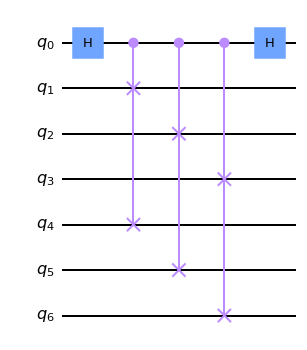

In [ ]:
_swap_test_operator(3).primitive.draw('mpl')

The first state $|\psi\rangle$ would, for instance, take qubits $q_1, q_2, q_3$ and the second state $|\phi\rangle$ would take $q_4, q_5, q_6$. The ancilla qubit, $q0$ is then measured and the probability of measuring zero $P_0$ is proportional to the overlap between the states, such that $$\text{Tr}\left[\rho_\psi\rho_\phi\right] = 2P_0 - 1.$$

The behaviour is analogous to the other overlap computation functions with the exception that `swap_test_overlap` does accept `QuantumCircuit` inputs, provided that it heavily relies on quantum circuit construction. 

See some function call examples below and refer to [the basic usage](https://borjarequena.github.io/Quantum-Fisherman/#Basic-usage) for a joint explanation of the overlap computation functions. 

In [ ]:
#hide
from qiskit.circuit import Parameter

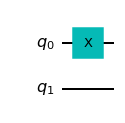

In [ ]:
qc0 = QuantumCircuit(2)
qc0.x(0)
qc0.draw('mpl')

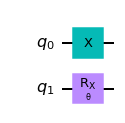

In [ ]:
theta0 = Parameter('θ')
qc1 = QuantumCircuit(2)
qc1.x(0)
qc1.rx(theta0, 1)
qc1.draw('mpl')

In [ ]:
state0 = CircuitStateFn(qc0)
purity = swap_test_overlap(state0)
purity

array([1.])

In [ ]:
theta_values = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
param_dict = {theta0: theta_values}

In [ ]:
state0 = CircuitStateFn(qc0)
state1 = CircuitStateFn(qc1).bind_parameters(param_dict)
overlaps = swap_test_overlap(state0, state1)
overlaps

array([ 1.        ,  0.47851562, -0.0078125 ,  0.44140625,  1.        ])

In [ ]:
param_state = CircuitStateFn(qc1)
overlaps = swap_test_overlap(param_state, param_dict=param_dict)
overlaps

array([[ 1.        ,  0.49609375,  0.0078125 ,  0.50195312,  1.        ],
       [ 0.49609375,  1.        ,  0.48242188,  0.03320312,  0.51171875],
       [ 0.0078125 ,  0.48242188,  1.        ,  0.50585938, -0.00976562],
       [ 0.50195312,  0.03320312,  0.50585938,  1.        ,  0.51171875],
       [ 1.        ,  0.51171875, -0.00976562,  0.51171875,  1.        ]])

In [ ]:
overlaps.diagonal()

array([1., 1., 1., 1., 1.])